In [0]:
from keras import backend as K
import time
import matplotlib.pyplot as plt
import numpy as np
% matplotlib inline
np.random.seed(2017) 
from keras.models import Sequential, Model
from keras.layers.convolutional import Convolution2D, MaxPooling2D, SeparableConvolution2D, DepthwiseConv2D
from keras.layers import Activation, Flatten, Dense, Dropout, Add,Input,concatenate
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils

In [0]:
from keras.datasets import cifar10
(train_features, train_labels), (test_features, test_labels) = cifar10.load_data()
num_train, img_channels, img_rows, img_cols =  train_features.shape
num_test, _, _, _ =  test_features.shape
num_classes = len(np.unique(train_labels))

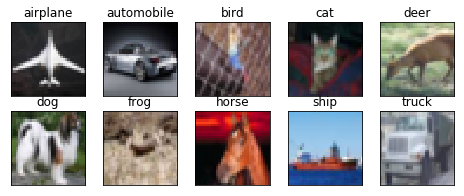

In [5]:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']
fig = plt.figure(figsize=(8,3))
for i in range(num_classes):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    idx = np.where(train_labels[:]==i)[0]
    features_idx = train_features[idx,::]
    img_num = np.random.randint(features_idx.shape[0])
    im = features_idx[img_num]
    ax.set_title(class_names[i])
    plt.imshow(im)
plt.show()

In [0]:
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

In [0]:
def accuracy(test_x, test_y, model):
    result = model.predict(test_x)
    predicted_class = np.argmax(result, axis=1)
    true_class = np.argmax(test_y, axis=1)
    num_correct = np.sum(predicted_class == true_class) 
    accuracy = float(num_correct)/result.shape[0]
    return (accuracy * 100)

In [0]:
train_features = train_features.astype('float32')/255
test_features = test_features.astype('float32')/255
# convert class labels to binary class labels
train_labels = np_utils.to_categorical(train_labels, num_classes)
test_labels = np_utils.to_categorical(test_labels, num_classes)

In [13]:
# Define the model
model_input=Input(shape=(img_channels, img_rows, img_cols))

l1=Convolution2D(64, (3, 3), border_mode='same',name='conv1')(model_input)
l1=BatchNormalization(name='bn_1')(l1)
l1=Activation('relu')(l1)
l1=Dropout(0.05)(l1)

#spacial Separable Convolution 
l2=Convolution2D(64, (1, 3), border_mode='same', name='ss_conv2')(l1)
l2=BatchNormalization(name='bn_2')(l2)
l2=Activation('relu')(l2)

l3=Convolution2D(64, (3, 1), border_mode='same', name='ss_conv3')(l2)
l3=BatchNormalization(name='bn_3')(l3)
l3=Activation('relu')(l3)

mp_1=MaxPooling2D(pool_size=(2, 2))(l3)

#Separable Convolution 
l4=SeparableConvolution2D(64, (3, 3), border_mode='same', name='s_conv4')(mp_1)
#l4=Activation('relu')(l5)
#l4=Dropout(0.05)(l5)

#Depthwise Convolution
#l5=DepthwiseConv2D((3,3),strides=(1, 1), padding='valid',use_bias=False)(l4)
#l5=Activation('relu')(l4)
#l4=Dropout(0.05)(l4)

mp_2=MaxPooling2D(pool_size=(2, 2))(l4)

#Grouped Convolution ( 3x3, 5x5)
l6=Convolution2D(64, (3, 3), border_mode='same', name='g_conv5')(mp_2)
l6=BatchNormalization(name='bn_6')(l6)
l6=Activation('relu')(l6)
l6=Dropout(0.05)(l6)

l7=Convolution2D(64, (5, 5), border_mode='same', name='g_conv6')(mp_2)
l7=BatchNormalization(name='bn_7')(l7)
l7=Activation('relu')(l7)
l7=Dropout(0.05)(l7)

concat_1= concatenate([l6,l7],axis=-1)
l8=Convolution2D(64,(1,1),border_mode='same', name='g_conv7')(concat_1)

#Grouped Convolution ( 3x3 , one with dilation = 1, and with dilation = 2) 
l9=Convolution2D(64, (3, 3), border_mode='same', name='g_conv8', dilation_rate=1)(l8)
l9=BatchNormalization(name='bn_9')(l9)
l9=Activation('relu')(l9)
l9=Dropout(0.05)(l9)

l10=Convolution2D(64, (3, 3), border_mode='same', name='g_conv9', dilation_rate=2)(l8)
l10=BatchNormalization(name='bn_10')(l10)
l10=Activation('relu')(l10)
l10=Dropout(0.05)(l10)

concat_2= concatenate([l9,l10],axis=-1)
l11=Convolution2D(64,(1,1),border_mode='same', name='g_conv10')(concat_2)

l12=Convolution2D(10, 8, 8)(l11)

l13=Flatten()(l12)

model_output=Activation('softmax')(l13)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), name="conv1", padding="same")`
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (1, 3), name="ss_conv2", padding="same")`
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 1), name="ss_conv3", padding="same")`
  del sys.path[0]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: UserWarning: Update your `SeparableConv2D` call to the Keras 2 API: `SeparableConv2D(64, (3, 3), name="s_conv4", padding="same")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:32: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), nam

* Because its not the sequential model we have to get the shape of images ie rows, columns and channels and saving it into one variable called model_input.

* Because its not sequential model we need to save the convolution to an variable and send that to the other function which is used further.

* l1 is variable name which stores the convolution value and send that as an input to the next function here batch normalization, the batch normalization value will be send as an input to the other function and continuous as many layer we have.

* Second layer is spacial separable convolution ie we will be using 1x3 and 3x1. spacial separable convolution is used to reduce the parameters.

* In l4 Depwise separable convolution is used first it will do the 3x3 and then it will do pointwise convlution that is 1x1.

* In l6 grouped convolution ie the output of the max polling  will be given to 3x3 and l7 5x5 after that concat both the values of different kernals because padding is used there wont be any problem while doing concatenation, after concat the parameters will be high, hence will use 1x1 to reduce the parametes

* l9 and l10 same group convolution but here we used dilation rate of 1 and 2, dilation 2 is sampling ie RF will get increased, ie RF can read the pixel instead one after other it will read alternate pixel which is used to avoid bluring the image, after that concat both and perform 1x1 to reduce the parameters.

* finally convolve with max kernal to get 10x1x1.
* flattern the image and perform the softmax.

* with the help of Model save the mode input and output to thee variable model as an object. 

In [14]:
model = Model(inputs=[model_input],outputs=[model_output])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 32, 32, 64)   1792        input_2[0][0]                    
__________________________________________________________________________________________________
bn_1 (BatchNormalization)       (None, 32, 32, 64)   256         conv1[0][0]                      
__________________________________________________________________________________________________
activation_9 (Activation)       (None, 32, 32, 64)   0           bn_1[0][0]                       
__________________________________________________________________________________________________
dropout_6 

In [0]:
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

* compile the model with the loss function
* run the model with 50 epoch 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., validation_data=(array([[[..., verbose=1, steps_per_epoch=390, epochs=50)`
  if sys.path[0] == '':


Epoch 1/50
390/390 [==============================] - 22s 56ms/step - loss: 1.3106 - acc: 0.5338 - val_loss: 1.4018 - val_acc: 0.5272
Epoch 2/50
390/390 [==============================] - 16s 42ms/step - loss: 0.8726 - acc: 0.6933 - val_loss: 1.2486 - val_acc: 0.5772
Epoch 3/50
390/390 [==============================] - 16s 41ms/step - loss: 0.6943 - acc: 0.7563 - val_loss: 0.8225 - val_acc: 0.7225
Epoch 4/50
390/390 [==============================] - 16s 42ms/step - loss: 0.5768 - acc: 0.7966 - val_loss: 0.9085 - val_acc: 0.7083
Epoch 5/50
390/390 [==============================] - 16s 42ms/step - loss: 0.4901 - acc: 0.8280 - val_loss: 0.7559 - val_acc: 0.7463
Epoch 6/50
390/390 [==============================] - 16s 41ms/step - loss: 0.4173 - acc: 0.8540 - val_loss: 0.7490 - val_acc: 0.7572
Epoch 7/50
390/390 [==============================] - 16s 41ms/step - loss: 0.3504 - acc: 0.8747 - val_loss: 0.7699 - val_acc: 0.7621
Epoch 8/50
390/390 [==============================] - 16s 41ms

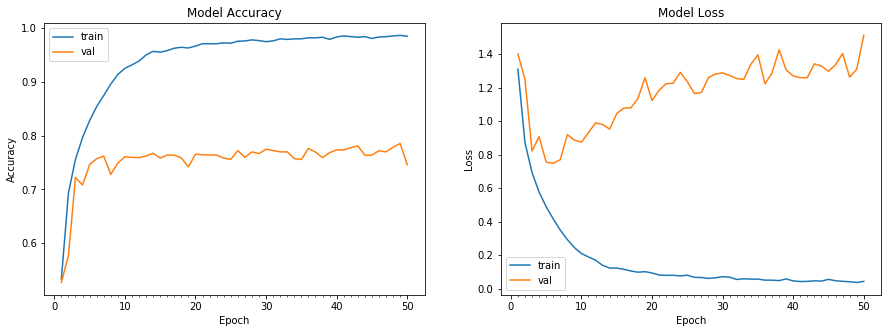

Accuracy on test data is: 74.61


In [16]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(zoom_range=0.0, 
                             horizontal_flip=False)


# train the model
start = time.time()
# Train the model
model_info = model.fit_generator(datagen.flow(train_features, train_labels, batch_size = 128),
                                 samples_per_epoch = train_features.shape[0], nb_epoch = 50, 
                                 validation_data = (test_features, test_labels), verbose=1)
end = time.time()
print ("Model took %0.2f seconds to train"%(end - start))
# plot model history
plot_model_history(model_info)
# compute test accuracy
print ("Accuracy on test data is: %0.2f"%accuracy(test_features, test_labels, model))